In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 
import sweetviz as sv
from scipy.stats import norm
from math import sqrt
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

### Input Data

In [2]:
tv_shows = pd.read_csv('C:/Users/Harshit Paliwal/Desktop/Fall 20/Applied Statistics/Project/tv_shows.csv')
data=pd.read_csv('C:/Users/Harshit Paliwal/Desktop/Fall 20/Applied Statistics/Project/tv_shows.csv')
df = pd.read_csv('C:/Users/Harshit Paliwal/Desktop/Fall 20/Applied Statistics/Project/MoviesOnStreamingPlatforms_updated.csv')
df1 = df
#Dataframes for each platform
netflix_shows = tv_shows.loc[tv_shows['Netflix'] == 1].drop(['Hulu', 'Prime Video', 'Disney+'], axis=1)
hulu_shows = tv_shows.loc[tv_shows['Hulu'] == 1].drop(['Netflix', 'Prime Video', 'Disney+'], axis=1)
prime_shows = tv_shows.loc[tv_shows['Prime Video'] == 1].drop(['Hulu', 'Netflix', 'Disney+'], axis=1)
disney_shows = tv_shows.loc[tv_shows['Disney+'] == 1].drop(['Hulu', 'Prime Video', 'Netflix'], axis=1)

tv_shows.head()



Unnamed: 0             Title  Year  Age  IMDb Rotten Tomatoes  Netflix  \
0           0      Breaking Bad  2008  18+   9.5             96%        1   
1           1   Stranger Things  2016  16+   8.8             93%        1   
2           2       Money Heist  2017  18+   8.4             91%        1   
3           3          Sherlock  2010  16+   9.1             78%        1   
4           4  Better Call Saul  2015  18+   8.7             97%        1   

   Hulu  Prime Video  Disney+  type  
0     0            0        0     1  
1     0            0        0     1  
2     0            0        0     1  
3     0            0        0     1  
4     0            0        0     1

In [3]:
df.head()

Unnamed: 0  ID                           Title  Year  Age  IMDb  \
0           0   1                       Inception  2010  13+   8.8   
1           1   2                      The Matrix  1999  18+   8.7   
2           2   3          Avengers: Infinity War  2018  13+   8.5   
3           3   4              Back to the Future  1985   7+   8.5   
4           4   5  The Good, the Bad and the Ugly  1966  18+   8.8   

  Rotten Tomatoes  Netflix  Hulu  Prime Video  Disney+  Type  \
0             87%        1     0            0        0     0   
1             87%        1     0            0        0     0   
2             84%        1     0            0        0     0   
3             96%        1     0            0        0     0   
4             97%        1     0            1        0     0   

                        Directors                            Genres  \
0               Christopher Nolan  Action,Adventure,Sci-Fi,Thriller   
1  Lana Wachowski,Lilly Wachowski                     Action,Sci-Fi   
2         Anthony Russo,Joe Russo           Action,Adventure,Sci-Fi   
3                 Robert Zemeckis           Adventure,Comedy,Sci-Fi   
4                    Sergio Leone                           Western   

                        Country                 Language  Runtime  
0  United States,United Kingdom  English,Japanese,French    148.0  
1                 United States                  English    136.0  
2                 United States                  English    149.0  
3                 United States                  English    116.0  
4      Italy,Spain,West Germany                  Italian    161.0

### Data Cleaning
#### Dropping duplicates based on title

In [4]:
tv_shows.drop_duplicates(subset='Title',keep='first',inplace=True)

#### Fill nulls with zeros and convert both of them into integers convert both ratings on common scale ie. on 100 Since ratings play a huge role we have to process Rotten Tomato ratings and Imdb ratings.

In [5]:
tv_shows['Rotten Tomatoes'] = tv_shows['Rotten Tomatoes'].fillna('0%')
tv_shows['Rotten Tomatoes'] = tv_shows['Rotten Tomatoes'].apply(lambda x : x.rstrip('%'))
tv_shows['Rotten Tomatoes'] = pd.to_numeric(tv_shows['Rotten Tomatoes'])

tv_shows['IMDb'] = tv_shows['IMDb'].fillna(0)
tv_shows['IMDb'] = tv_shows['IMDb']*10
tv_shows['IMDb'] = tv_shows['IMDb'].astype('int')

### Wide to Long Format Conversion
#### Plotting of the charts would be easier if we get the 1s and 0s in the columns Netflix,Hulu,Disney+ & Prime Video under a categorical section videos, also there might be cases wherin the same show is present in more than one service.

In [6]:
tv_shows_long=pd.melt(tv_shows[['Title','Netflix','Hulu','Disney+','Prime Video']],id_vars=['Title'],var_name='StreamingOn', value_name='Present')
tv_shows_long = tv_shows_long[tv_shows_long['Present'] == 1]
tv_shows_long.drop(columns=['Present'],inplace=True)

### Merging Datasets
#### Merging Long Format dataset with dataset that we started with also need to drop unwanted columns.

In [7]:
tv_shows_combined = tv_shows_long.merge(tv_shows, on='Title', how='inner')
tv_shows_combined.drop(columns = ['Unnamed: 0','Netflix','Hulu', 'Prime Video', 'Disney+', 'type'], inplace=True)

### Subsetting
### The datasets with IMDB ratings/ Rotten Tomatoes ratings above 0 needs to be considered for plotting.

In [8]:
tv_shows_both_ratings = tv_shows_combined[(tv_shows_combined.IMDb > 0) & tv_shows_combined['Rotten Tomatoes'] > 0]
tv_shows_both_ratings.head()

Title StreamingOn  Year  Age  IMDb  Rotten Tomatoes
1   Stranger Things     Netflix  2016  16+    88               93
2       Money Heist     Netflix  2017  18+    84               91
4  Better Call Saul     Netflix  2015  18+    87               97
5        The Office     Netflix  2005  16+    89               81
6      Black Mirror     Netflix  2011  18+    88               83

### Plotting
#### (1) To get the Service with the most content.

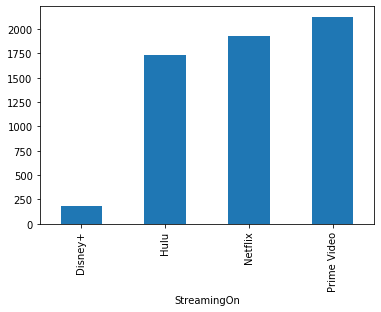

In [9]:
tv_shows_combined.groupby('StreamingOn').Title.count().plot(kind='bar')

#### (2) Violin charts to gauge the content rating(IMDB) and freshness (Rotten Tomatoes) accross all the streaming service.

In [10]:
figure = []
figure.append(px.violin(tv_shows_both_ratings, x = 'StreamingOn', y = 'IMDb', color='StreamingOn'))
figure.append(px.violin(tv_shows_both_ratings, x = 'StreamingOn', y = 'Rotten Tomatoes', color='StreamingOn'))
fig = make_subplots(rows=2, cols=4, shared_yaxes=True)

for i in range(2):
    for j in range(4):
        fig.add_trace(figure[i]['data'][j], row=i+1, col=j+1)

fig.update_layout(autosize=False, width=800, height=800)        
fig.show()

#### (3) Scatter plot between IMDB and Rotten tomatoes ratings to get the streaming service that has best of both worlds.

In [11]:
px.scatter(tv_shows_both_ratings, x='IMDb',y='Rotten Tomatoes',color='StreamingOn')

### Inference

#### (1) Bar Plot
#### Amazon Prime wins this race in this one.
#### So looking at all three we can conclude Amazon Prime is both about quality and quantity.

#### (2) Scatter Plot
#### With this another view, it is quite evident, Amazon Prime performs very well in the fourth quadarant. Which verifies our first inference

#### (3) Violin Chart
#### Hulu, Netflix and Amazon Videos all three have got substantial data in lower end of the ratings.As the content increases so the quality decreases for all three.
#### Prime Videos have got a denser in the top half on looking at the IMDB and performs ok in freshness.
#### Disney+ being new has done very well in this area as well.


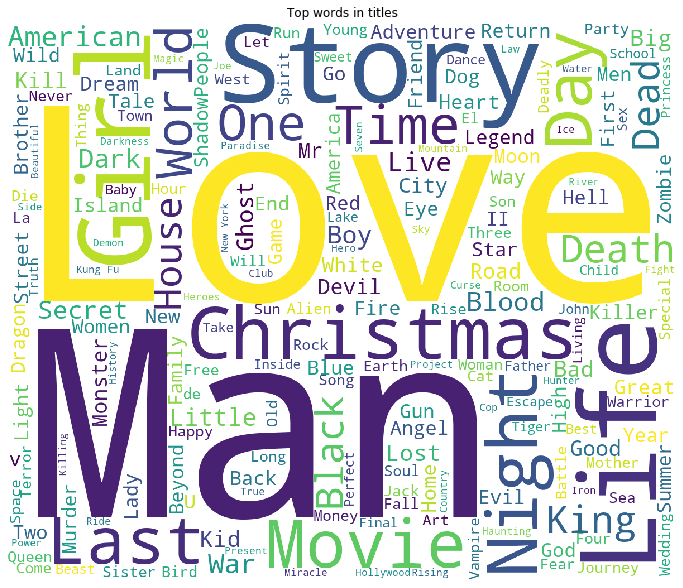

In [12]:
plt.figure(figsize = (12, 12))
text = ' '.join(df['Title'].values)
wordcloud = WordCloud(max_font_size=None,
                      background_color='white',
                      width=1200,
                      height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

In [13]:
#analyzing the dataset
advert_report = sv.analyze(data)
#display the report
advert_report.show_html('Tv_shows.html')

netflix_sum = tv_shows['Netflix'].sum()
hulu_sum = tv_shows['Hulu'].sum()
prime_sum = tv_shows['Prime Video'].sum()
disney_sum = tv_shows['Disney+'].sum()


Report Tv_shows.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Top 10 highest rating shows by IMDb

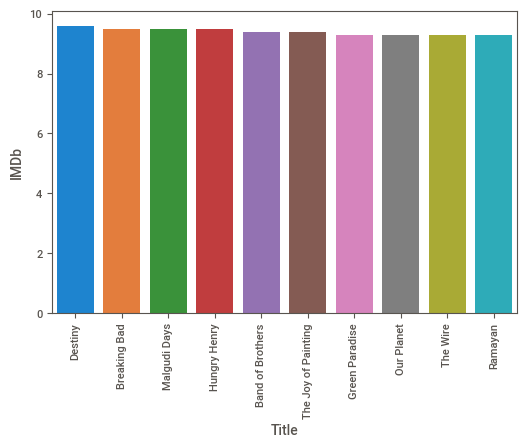

In [14]:
x=data.sort_values(by='IMDb',ascending=False).iloc[:10]
sns.barplot(data=x,x='Title',y='IMDb')
plt.xticks(rotation=90)
plt.show()

### Which year had the largest amount of shows released

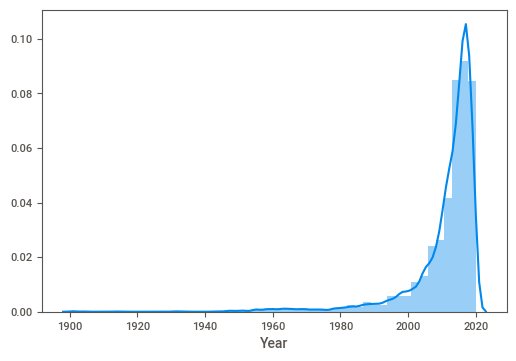

In [15]:
sns.distplot(data['Year'])

#### From this we can see that large amount of shows were released between the year 2010 - 2020

### The Age distribution of the shows

In [16]:
def count(name):
    arr=data[name].values
    dic={}
    for i in arr:
        if i not in dic:
            dic[i]=1
        else:
            dic[i]+=1
    return dic
dic=count('Age')
del dic[np.nan]
fig = px.pie(data, names=list(dic.keys()), values=list(dic.values()), title='Age distribution of the tv shows')
fig.show()

#### From this we can see we have a large number of nan values in the age group and the most of the tv shows are rated 16+ which can be the largest watching group among all

### Which services are best suited for children?

['18+' '16+' '7+' nan 'all' '13+']


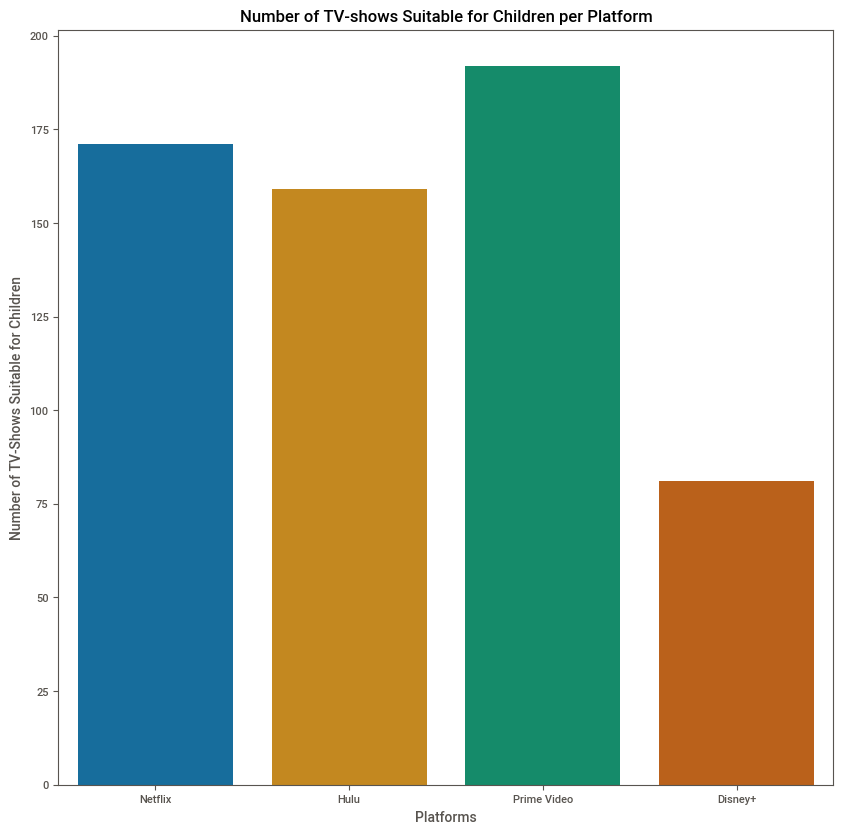

Netflix has 171 tv-shows for children
Hulu has 159 tv-shows for children
Prime has 192 tv-shows for children
Disney+ has 81 tv-shows for children


In [17]:
print(tv_shows.Age.unique())
tv_shows['platform'] = tv_shows[['Netflix', 'Hulu', 'Prime Video', 'Disney+']].idxmax(axis=1)

#'all' signifies they are suitable for children, which platforms are best subscribed to for children entertainment?

net_child = netflix_shows[netflix_shows['Age'] == 'all']
hulu_child = hulu_shows[hulu_shows['Age'] == 'all']
prime_child = prime_shows[prime_shows['Age'] == 'all']
disney_child = disney_shows[disney_shows['Age'] == 'all']

net1 = len(net_child['Title'])
hulu1 = len(hulu_child['Title'])
prime1 = len(prime_child['Title'])
disney1 = len(disney_child['Title'])

children_sum = ({
    'platforms' : ['Netflix',
                   'Hulu',
                   'Prime Video',
                  'Disney+'],
    'sums' : [net1,
               hulu1,
               prime1,
               disney1]
})
plt.figure(figsize=(10,10))
sns.barplot(x = children_sum['platforms'],
           y = children_sum['sums'],
           palette = 'colorblind')

plt.xlabel('Platforms')
plt.ylabel('Number of TV-Shows Suitable for Children')
plt.title('Number of TV-shows Suitable for Children per Platform')

plt.show()

print('Netflix has ' + str(net1) + ' tv-shows for children')
print('Hulu has ' + str(hulu1) + ' tv-shows for children')
print('Prime has ' + str(prime1) + ' tv-shows for children')
print('Disney+ has ' + str(disney1) + ' tv-shows for children')

#### Prime has the most tv-shows suitable for children, but what about concentration of tv-shows for children, as the platform with the highest concentration is likely to be much more tailored towards children and have tv-shows that are made specifically for children

### Which platform has the highest concentration of tv-shows for children?

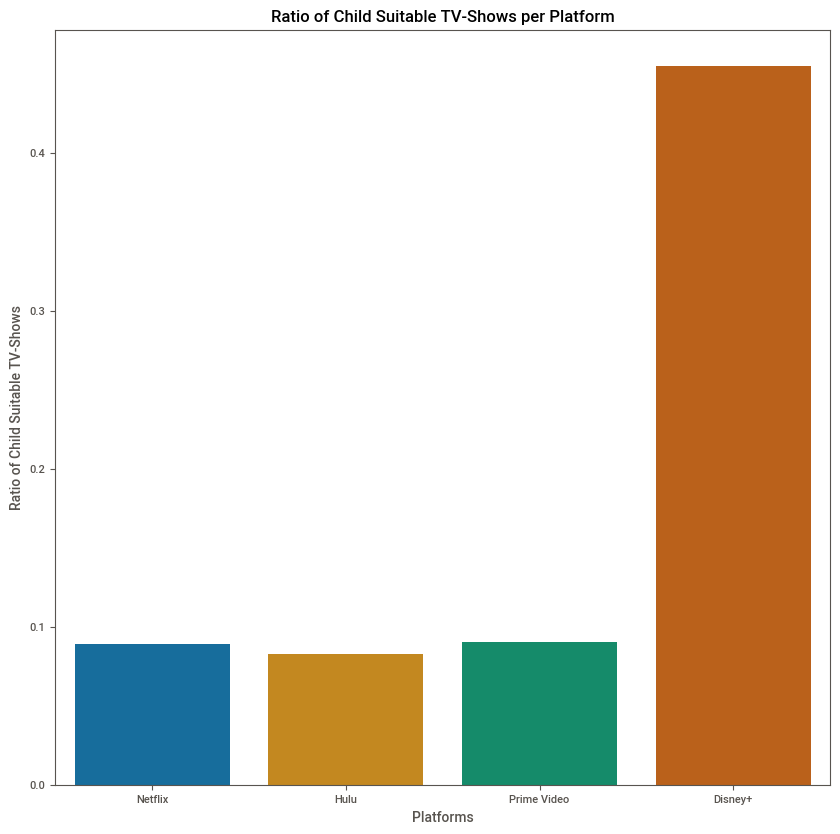

0.4550561797752809


In [18]:
ratio1_netflix = net1 / netflix_sum
ratio1_hulu = hulu1 / netflix_sum
ratio1_prime = prime1 / prime_sum
ratio1_disney = disney1 / disney_sum

children_show_ratios = ({
    'platforms' : ['Netflix',
                   'Hulu',
                   'Prime Video',
                  'Disney+'],
    'ratios' : [ratio1_netflix,
               ratio1_hulu,
               ratio1_prime,
               ratio1_disney]
})

plt.figure(figsize=(10,10))
sns.barplot(x = children_show_ratios['platforms'],
           y = children_show_ratios['ratios'],
           palette = 'colorblind')

plt.xlabel('Platforms')
plt.ylabel('Ratio of Child Suitable TV-Shows')
plt.title('Ratio of Child Suitable TV-Shows per Platform')

plt.show()
print(ratio1_disney)

####  Evidently Disney+ is much more child-friendly than the 3 alternatives, with a 4-fold greater difference in the ratio of child-friendly tv-shows on Disney+ in comparison.

### The distribution of the tv shows on different platforms

In [19]:
def count_platform(data):
    dic={'Netflix':0,'Hulu':0,'Disney+':0,'Prime Video':0}
    for i in data[['Netflix','Hulu','Disney+','Prime Video']].values:
        if i[0]==1:
            dic['Netflix']+=1
        if i[1]==1:
            dic['Hulu']+=1
        if i[2]==1:
            dic['Disney+']+=1
        if i[3]==1:
            dic['Prime Video']+=1
    return dic
dic=count_platform(data)
fig = px.pie(data, values=list(dic.values()), names=list(dic.keys()), title='Platform Distribution of this data')
fig.show()

#### As we can see that most of the tv shows are from the Amazon Prime Video followed by netflix hulu and Disney+

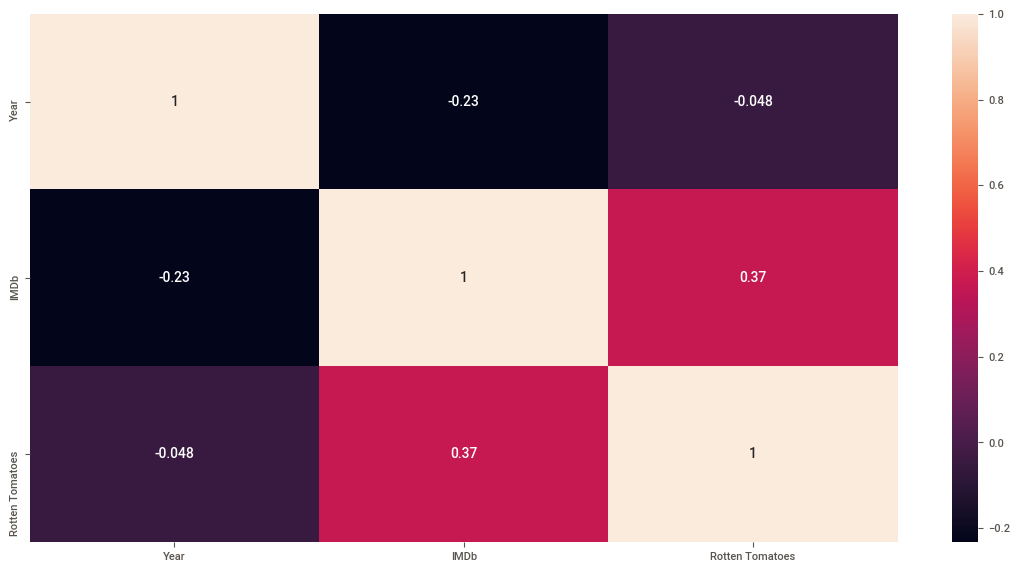

In [20]:
tv_shows_ratings = tv_shows_combined[(tv_shows_combined.IMDb > 0) & tv_shows_combined['Rotten Tomatoes'] > 0]
corr = tv_shows_ratings.corr(method='kendall')
plt.figure(figsize=(14,7))
sns.heatmap(corr, annot=True)

### Hypothesis Testing

#### A one-tailed test is a statistical test in which the critical area of a distribution is one-sided so that it is either greater than or less than a certain value, but not both. If the sample being tested falls into the one-sided critical area, the alternative hypothesis will be accepted instead of the null hypothesis.

In [21]:
def one_sided_mean_hypo(sample_mean_x,sample_mean_y,std_dev_x,std_dev_y,sample_size_x,sample_size_y,alpha):
    actual_z = abs(norm.ppf(alpha))
    hypo_z = ((sample_mean_x - sample_mean_y)/sqrt(((std_dev_x*std_dev_x)/(sample_size_x))+((std_dev_y*std_dev_y)/(sample_size_y))))
    print('actual_z:',actual_z)
    print('hypo_z:',hypo_z)
    if(hypo_z >= actual_z):
        return True
    else:
        return False

#### A two-tailed test is a method in which the critical area of a distribution is two-sided and tests whether a sample is greater or less than a range of values. If the sample being tested falls into either of the critical areas, the alternative hypothesis is accepted instead of the null hypothesis.

In [22]:
def two_sided_mean_hypo(sample_mean_x,sample_mean_y,std_dev_x,std_dev_y,sample_size_x,sample_size_y,alpha):
    actual_z = abs(norm.ppf(alpha))
    hypo_z = ((sample_mean_x - sample_mean_y)/sqrt(((std_dev_x*std_dev_x)/(sample_size_x))+((std_dev_y*std_dev_y)/(sample_size_y))))
    print('actual_z:',actual_z)
    print('hypo_z:',hypo_z)
    if(hypo_z >= actual_z or hypo_z <=-(actual_z)):
        return True
    else:
        return False
    

#### Calcution of mean rating and standard deviation of movies released after 2000 form a sample size of 500

In [23]:
new_rating_sum=0
new_rating_num=0

for i, row in df.iterrows():
    if(row[3]>=2000 and new_rating_num<500):
        new_rating_num+=1
        if(row[5]>0):
            new_rating_sum+=row[5]
        

print(new_rating_num,new_rating_sum,new_rating_sum/new_rating_num);
new_rating_mean=new_rating_sum/new_rating_num

new_rating_std=0
new_rating_num=0
for i, row in df.iterrows():
    if(row[3]>2000 and new_rating_num<500):
        new_rating_num+=1
        if(row[5]>0):
            new_rating_std+= (row[5]-(new_rating_mean))*(row[5]-(new_rating_mean))

new_rating_std = new_rating_std/(new_rating_num)
new_rating_std = sqrt(new_rating_std)
print(new_rating_std)

500 3593.1999999999994 7.186399999999999
0.6108775327346715


#### Calcution of mean rating and standard deviation of movies released before 2000 form a sample size of 500

In [24]:
rating_sum=0
rating_num=0

for i, row in df.iterrows():
    if(row[3]<2000 and rating_num<400):
        rating_num+=1
        if(row[5]>0):
            rating_sum+=row[5]
        

print(rating_num,rating_sum,rating_sum/rating_num);
rating_mean=rating_sum/rating_num

rating_std=0
rating_num=0;
for i, row in df.iterrows():
    if(row[3]<=2000 and rating_num<400 ):
        rating_num+=1;
        if(row[5]>0):
            rating_std+= (row[5]-(rating_mean))*(row[5]-(rating_mean))

rating_std = rating_std/(rating_num)
rating_std = sqrt(rating_std)
print(rating_std)

400 2736.0000000000023 6.840000000000006
0.9923824867459127


#### Null hypothesis: There’s no significant difference in the proportion of well rated movies between movies from the XX and XXI century

#### H0: : μx - μy = 0

#### Alternative hypothesis: There’s significant difference in the proportion of well rated movies between movies from the XX and XXI century

#### HA: μx - μy != 0

#### In accordance to our result employing a two tailed Z-test do suggest that there’s significant difference in the proportion of well rated movies between movies from the XX and XXI century.

In [25]:
alpha  = 0.05
sample_mean_x =  new_rating_mean
sample_mean_y = rating_mean
sample_size_x = new_rating_num
sample_size_y = rating_num
std_dev_x = new_rating_std
std_dev_y = rating_std

print("H0 : μx - μy = 0")
print('H1 : μx - μy != 0')
print("alpha value is :", alpha,'\n')

rej = two_sided_mean_hypo(sample_mean_x,sample_mean_y,std_dev_x,std_dev_y,sample_size_x,sample_size_y,alpha)
if rej:
    print("Reject NULL Hypothesis")
else:
    print("Failed to reject NULL hypothesis")

H0 : μx - μy = 0
H1 : μx - μy != 0
alpha value is : 0.05 

actual_z: 1.6448536269514729
hypo_z: 6.11552315156307
Reject NULL Hypothesis


#### Calcution of mean runtime and standard deviation of movies released after 2000 form a sample size of 500

In [26]:
new_sum=0
new_num=0
for i, row in df.iterrows():
    if(row[3]>=2000 and new_num<500):
        new_num+=1
        if(row[-1]>0):
            new_sum+=row[-1]

print(new_sum,new_num,new_sum/new_num)
new_mean = new_sum/new_num

new_std=0
new_num=0
for i, row in df.iterrows():
    if(row[3]>1990 and new_num<500):
        new_num+=1
        if(row[-1]>0):
            new_std+= (row[-1]-(new_mean))*(row[-1]-(new_mean))

new_std = new_std/(new_num)
new_std = sqrt(new_std)
print(new_std)

54570.0 500 109.14
25.578463612969397


#### Calcution of mean runtime and standard deviation of movies released before 2000 form a sample size of 500

In [27]:
old_sum=0
old_num=0
for i, row in df.iterrows():
    if(row[3]<2000 and old_num<500):
        old_num+=1
        if(row[-1]>0):
            old_sum+=row[-1]

print(old_sum,old_num,old_sum/old_num)
old_mean = old_sum/old_num

old_std=0
old_num=0
for i, row in df.iterrows():
    if(row[3]<=1990 and old_num<500):
        old_num+=1
        if(row[-1]>0):
            old_std+= (row[-1]-(old_mean))*(row[-1]-(old_mean))

old_std = old_std/(old_num)
old_std = sqrt(old_std)
print(old_std)

51869.0 500 103.738
39.3325075784395


#### Null hypothesis: The movie runtime has not increased from XX and XXI century

#### H0 : μx - μy <= 0

#### Alternative hypothesis: There’s significant increase in the movie runtime from XX and XXI century

#### H1 : μx - μy > 0

#### In accordance to our result employing a one tailed Z-test do suggest that there’s increase in the movie runtime from XX and XXI century.

In [28]:
alpha  = 0.05
sample_mean_x =  new_mean
sample_mean_y = old_mean
sample_size_x = new_num
sample_size_y = old_num
std_dev_x = new_std
std_dev_y = old_std

print("H0 : μx - μy <= 0")
print('H1 : μx - μy > 0')
print("alpha value is :", alpha,'\n')

rej = one_sided_mean_hypo(sample_mean_x,sample_mean_y,std_dev_x,std_dev_y,sample_size_x,sample_size_y,alpha)
if rej:
    print("Reject NULL Hypothesis")
else:
    print("Failed to reject NULL hypothesis")

H0 : μx - μy <= 0
H1 : μx - μy > 0
alpha value is : 0.05 

actual_z: 1.6448536269514729
hypo_z: 2.574539594036462
Reject NULL Hypothesis


### TV Show Clustering based on ratings

In [29]:
ratings=data[["Title",'IMDb',"Rotten Tomatoes"]]
ratings.head()

Title  IMDb Rotten Tomatoes
0      Breaking Bad   9.5             96%
1   Stranger Things   8.8             93%
2       Money Heist   8.4             91%
3          Sherlock   9.1             78%
4  Better Call Saul   8.7             97%

In [30]:
ratings=ratings.dropna()
ratings["IMDb"]=ratings["IMDb"]*10
ratings['Rotten Tomatoes'] = (ratings['Rotten Tomatoes'].str[:-1].astype(float))

In [31]:
X=ratings[["IMDb","Rotten Tomatoes"]]

#### KMeans is one of the simple but popular unsupervised learning algorithm. Here K indicates the number of clusters or classes the algorithm has to divide the data into. The algorithm starts with first group of randomly selected centroids, which are used as the beginning points for every cluster. It performs repetitive calculations to optimize the positions of the centroids.

#### Now we calculate the Within Cluster Sum of Squared Errors (WSS) for different values of k. Next, we choose the k for which WSS first starts to diminish.

In [32]:
wcss=[]

for i in range(1,11):
    km=KMeans(n_clusters=i)
    km.fit(X)
    wcss.append(km.inertia_)
print(wcss)

[518145.3650793651, 196771.39860139863, 126340.58764623248, 99566.8877469934, 82736.69423493248, 70099.54419778491, 62767.32824106928, 55163.77042045114, 49711.07639208555, 43718.411010708944]


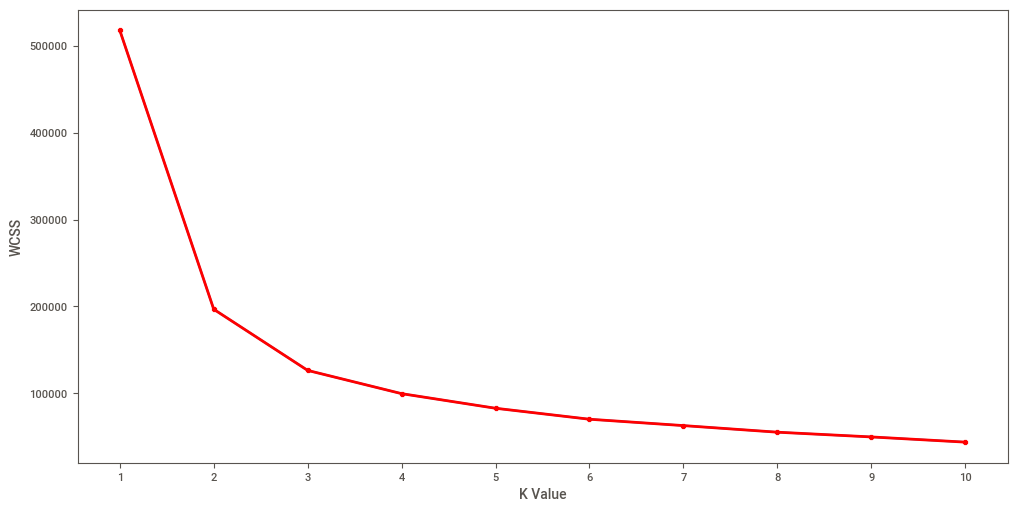

In [33]:
#The elbow curve

plt.figure(figsize=(12,6))

plt.plot(range(1,11),wcss)

plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")

plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")

plt.show()

#### This is known as the elbow graph , the x axis being the number of clusters
#### The number of clusters is taken at the elbow joint point
#### This point is the point where making clusters is most relevant
#### The numbers of clusters is kept at maximum

In [34]:
#Taking 4 clusters
km=KMeans(n_clusters=4)

#Fitting the input data
km.fit(X)

#predicting the labels of the input data
y=km.predict(X)

#adding the labels to a column named label
ratings["label"] = y

#The new dataframe with the clustering done
ratings.head()

Title  IMDb  Rotten Tomatoes  label
0      Breaking Bad  95.0             96.0      1
1   Stranger Things  88.0             93.0      1
2       Money Heist  84.0             91.0      1
3          Sherlock  91.0             78.0      1
4  Better Call Saul  87.0             97.0      1

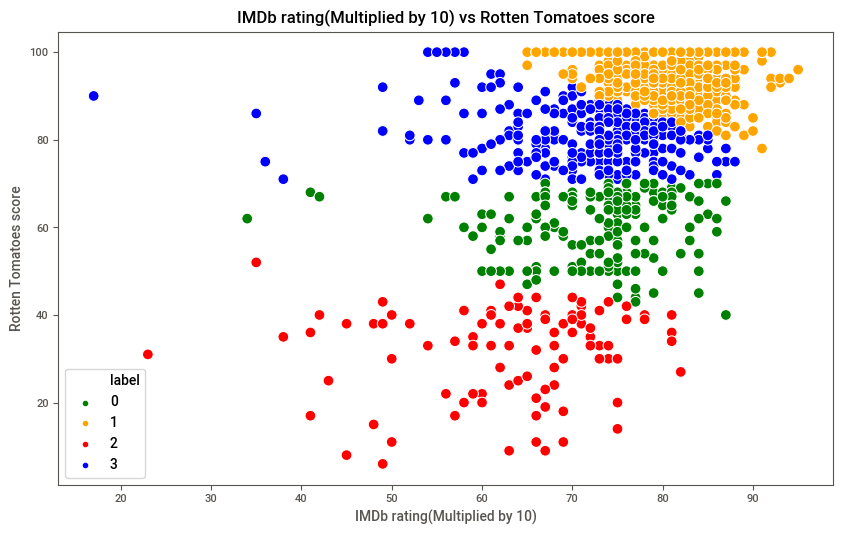

In [35]:
#Scatterplot of the clusters

plt.figure(figsize=(10,6))
sns.scatterplot(x = 'IMDb',y = 'Rotten Tomatoes',hue="label",  
                 palette=['green','orange','red',"blue"], legend='full',data = ratings  ,s = 60 )

plt.xlabel('IMDb rating(Multiplied by 10)')
plt.ylabel('Rotten Tomatoes score') 
plt.title('IMDb rating(Multiplied by 10) vs Rotten Tomatoes score')
plt.show()


### Analysis

#### The cluster at the top are surely the best TV Shows, they have high scores by both IMDb and Rotten Tomatoes.

#### The middle two are good and average TV Shows. There are outliers, and in some cases, some TV Shows have been rated high by one, but rated low by the other.

#### The outliers are mainly caused by the fact that, say IMDb rated them well, but Rotten Tomatoes rated them badly.

#### The bottom cluster is usually the TV Shows with bad ratings by both, but there are some outliers.

In [36]:
print('Number of Cluster 0 TV Shows are=')
print(len(ratings[ratings["label"]==0]))
print("--------------------------------------------")
print('Number of Cluster 1 TV Shows are=')
print(len(ratings[ratings["label"]==1]))
print("--------------------------------------------")
print('Number of Cluster 2 TV Shows are=')
print(len(ratings[ratings["label"]==2]))
print("--------------------------------------------")
print('Number of Cluster 3 TV Shows are=')
print(len(ratings[ratings["label"]==3]))
print("--------------------------------------------")

Number of Cluster 0 TV Shows are=
186
--------------------------------------------
Number of Cluster 1 TV Shows are=
423
--------------------------------------------
Number of Cluster 2 TV Shows are=
100
--------------------------------------------
Number of Cluster 3 TV Shows are=
299
--------------------------------------------


### Creating Reccomendation system (only for movies and tv_shows available on netflix.)

In [37]:
df=pd.read_csv('C:/Users/Harshit Paliwal/Desktop/Fall 20/Applied Statistics/Project/netflix_titles.csv')
data = df[['title','director','cast','listed_in','description']]
df.head()

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   
3  80058654  TV Show         Transformers: Robots in Disguise   
4  80125979    Movie                             #realityhigh   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   
3                       NaN   
4          Fernando Lebrija   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   
3  Will Friedle, Darren Criss, Constance Zimmer, ...   
4  Nesta Cooper, Kate Walsh, John Michael Higgins...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   
3                             United States  September 8, 2018          2016   
4                             United States  September 8, 2017          2017   

     rating  duration                           listed_in  \
0     TV-PG    90 min  Children & Family Movies, Comedies   
1     TV-MA    94 min                     Stand-Up Comedy   
2  TV-Y7-FV  1 Season                            Kids' TV   
3     TV-Y7  1 Season                            Kids' TV   
4     TV-14    99 min                            Comedies   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...  
3  When a prison ship crash unleashes hundreds of...  
4  When nerdy high schooler Dani finally attracts...

In [38]:
rake = Rake()

In [39]:
data['director'] = data['director'].fillna(' ')
data['director'] = data['director'].astype(str)
data['cast'] = data['cast'].fillna(' ')
data['cast'] = data['cast'].astype(str)

In [40]:
data['key_notes'] = ''
for index,row in data.iterrows():
    plot = row['description']
    
    rake.extract_keywords_from_text(plot)
    keyword_score = rake.get_word_degrees()
    
    genre = ''.join(row['listed_in'].split(',')).lower()
    director = ''.join(row['director'].replace(' ','').split(',')).lower()
    cast = ' '.join(row['cast'].replace(' ','').split(',')).lower()
    keyword_score = ' '.join(list(keyword_score.keys()))
    
    row['key_notes'] = genre + ' ' + ' ' + director + ' ' + cast + ' ' + keyword_score

recommend = data[['title','key_notes']]
recommend.head()


title  \
0  Norm of the North: King Sized Adventure   
1               Jandino: Whatever it Takes   
2                       Transformers Prime   
3         Transformers: Robots in Disguise   
4                             #realityhigh   

                                           key_notes  
0  children & family movies comedies  richardfinn...  
1  stand-up comedy   jandinoasporaat serenades fi...  
2  kids' tv   petercullen sumaleemontano frankwel...  
3  kids' tv   willfriedle darrencriss constancezi...  
4  comedies  fernandolebrija nestacooper katewals...

In [41]:
cv = CountVectorizer()
count_mat = cv.fit_transform(recommend['key_notes'])
cosine_sim = cosine_similarity(count_mat,count_mat)
print(cosine_sim)

[[1.         0.         0.         ... 0.0942809  0.03086067 0.03390318]
 [0.         1.         0.04472136 ... 0.         0.         0.        ]
 [0.         0.04472136 1.         ... 0.         0.10141851 0.07427814]
 ...
 [0.0942809  0.         0.         ... 1.         0.         0.        ]
 [0.03086067 0.         0.10141851 ... 0.         1.         0.21971769]
 [0.03390318 0.         0.07427814 ... 0.         0.21971769 1.        ]]


In [42]:
indices = pd.Series(recommend['title'])
def recommend_movie(name):
    movie=[]
    idx = indices[indices == name].index[0]
    sort_index = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    recommendation_5= sort_index.iloc[1:6]
    for i in recommendation_5.index:
        movie.append(indices[i])
    return movie

In [43]:
def rec():
    try:
        i = 1
        while(i > 0):
            name = input("Enter The Name of a Movie or Tv Show: ")
            if name.lower() == 'quit':
                break
            else:
                print(recommend_movie(name))

    except KeyboardInterrupt:
        print("The movie or Tv Show does not exist\n")
        rec()

    except IndexError:
        print("The movie or Tv Show does not exist\n")
        rec()
        

print("To exit Enter \"quit\" \n")
rec()

To exit Enter "quit" 

Enter The Name of a Movie or Tv Show: The Witcher
['Argon', "Marvel's Iron Fist", 'Disappearance', 'The Umbrella Academy', "Oh No! It's an Alien Invasion"]
Enter The Name of a Movie or Tv Show: Poseidon
['Monsters: Dark Continent', 'Highway', 'Faraar', 'The Legacy of a Whitetail Deer Hunter', 'Mohenjo Daro']
Enter The Name of a Movie or Tv Show: Inception
['Apollo 18', 'Forbidden Planet', 'Limitless', 'The Darkest Dawn', 'Spider-Man 3']
Enter The Name of a Movie or Tv Show: Anaconda
The movie or Tv Show does not exist

Enter The Name of a Movie or Tv Show: quit
